In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
DATASET_PATH = "../datasets/dblp.txt"

In [4]:
df = pd.read_csv(DATASET_PATH, sep="\t", names=["source", "target"])

In [5]:
df.head()

,source,target
0,0,1
1,0,2
2,0,4519
3,0,23073
4,0,33043


In [6]:
vis_graph = nx.from_pandas_edgelist(df.head(140))
graph = nx.from_pandas_edgelist(df)

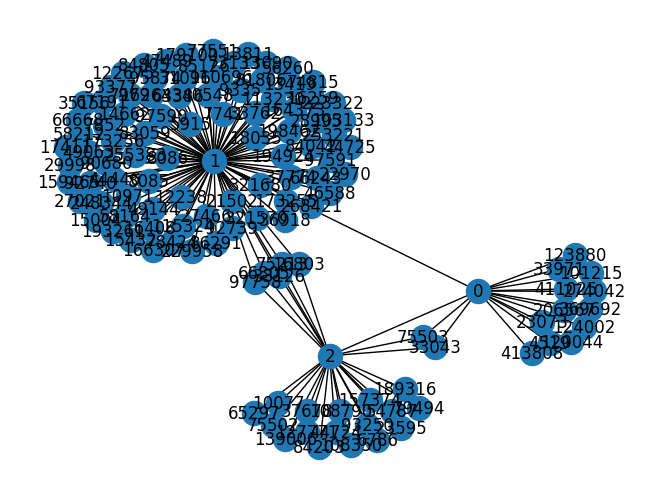

In [7]:
nx.draw(vis_graph, font_weight='light', with_labels=True)

In [27]:
def kshell(graph: nx.Graph, i):
    return nx.core_number(graph)[i]

def max_kshell(graph: nx.Graph):
    return max(nx.core_number(graph).values())

def min_kshell(graph: nx.Graph):
    return min(nx.core_number(graph).values())


In [28]:
def gravity_centrality(graph: nx.Graph, node: int) -> float:
    influence_radius = 3
    neighbors = set()
    for i in graph.nodes():
        if nx.shortest_path_length(graph, i, node) <= influence_radius:
            neighbors.add(i)

    acc = 0
    for j in neighbors:
        num = kshell(graph, node) * kshell(graph, j)
        distance = nx.shortest_path_length(graph, node, j)
        acc = num / distance

    return acc

In [ ]:
def gravitational_force(graph: nx.Graph, i: int, j: int):
    degree_prod = graph.degree[i] * graph.degree[j]
    distance = nx.shortest_path_length(graph, i, j)

    grav_coeff = np.power(np.e, )

In [32]:
# for node in graph.nodes():
#     for delta in range(6, 17):
#         delta = delta / 10

gravity_centrality(graph, 1)
# nx.Graph.nodes/